# Parts-of-Speech (POS) Tagging
the main difference between this task and the previous is this many-to-many, previous was many-to-one
- nasıl ya bi önceki task text classificationdı, yine many-to-many değil mi?
- haaa hayır bi önceki produce one output for the final output it reads in, yani mesela tüm makaleyi alıyo ve okuyo ama en son tüm makale için tek bi class sonucu veriyo
- oysa bu tüm makaleyi mesela okuycak ve makaledeki her bi kelime için POS tagging yapacak, ama RNN olmak zorunda çünkü aynı kelimenin tag'i öncesindeki sonrasındaki bağlama baplı değişebiliyo
- yani output is also a timeseries


In [1]:
import nltk
from nltk.corpus import brown

nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/yagmuraslan/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/yagmuraslan/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [2]:
#retrive the corpus from the module imported, by calling the tagged_sents function
#note that we specify the tagset as universal which gives us slightly different targets than default
corpus = brown.tagged_sents(tagset='universal')
corpus

#as you see it's essentially a list of list of tuples

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [3]:
len(corpus)

57340

In [18]:
#next step is to separate inputs and targets (tags)
#the output will be two list
inputs = [] #gonna be a list of lists of words
targets = [] #gonna be a list of lists of tags

for sentence_tag_pairs in corpus:
    tokens = []
    target = []
    for token, tag in sentence_tag_pairs: #list of list of tuples olduğu için böyle yapıyoz
        tokens.append(token)
        target.append(tag)
    inputs.append(tokens)
    targets.append(target) 

In [19]:
inputs #list içindeki her list ayrı bi cümle

[['The',
  'Fulton',
  'County',
  'Grand',
  'Jury',
  'said',
  'Friday',
  'an',
  'investigation',
  'of',
  "Atlanta's",
  'recent',
  'primary',
  'election',
  'produced',
  '``',
  'no',
  'evidence',
  "''",
  'that',
  'any',
  'irregularities',
  'took',
  'place',
  '.'],
 ['The',
  'jury',
  'further',
  'said',
  'in',
  'term-end',
  'presentments',
  'that',
  'the',
  'City',
  'Executive',
  'Committee',
  ',',
  'which',
  'had',
  'over-all',
  'charge',
  'of',
  'the',
  'election',
  ',',
  '``',
  'deserves',
  'the',
  'praise',
  'and',
  'thanks',
  'of',
  'the',
  'City',
  'of',
  'Atlanta',
  "''",
  'for',
  'the',
  'manner',
  'in',
  'which',
  'the',
  'election',
  'was',
  'conducted',
  '.'],
 ['The',
  'September-October',
  'term',
  'jury',
  'had',
  'been',
  'charged',
  'by',
  'Fulton',
  'Superior',
  'Court',
  'Judge',
  'Durwood',
  'Pye',
  'to',
  'investigate',
  'reports',
  'of',
  'possible',
  '``',
  'irregularities',
  "''",
 

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional #bidirectional ne acaba
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

2023-06-22 15:04:49.766308: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    inputs,
    targets,
    test_size=0.3,
)

In [7]:
# Convert sentences to sequences

MAX_VOCAB_SIZE = None #so we'll get a unique tag for each word

# capitalization might be useful - test it
should_lowercase = False #we will not lowercase the words since a capitlaized word might have a diff meaning than a lowercase wrd, ex: bill
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=should_lowercase,
    oov_token='UNK', #out-of-vocab token very important
)
#this is a many-to-many task, normally tokenizer object simply ignores the word not in its vocab 
#and not convert it to integer
# in many-tomany task, we'll have also a sequence of tags as the target
# otherwise unknown tokens will be removed and len(input) != len(target)
# and you won't even notice it bcz there will be padding
# input words and target words will not be aligned!

word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)


In [8]:
# get word -> integer mapping
word2idx = word_tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 47399 unique tokens.


In [9]:
# https://stackoverflow.com/questions/11264684/flatten-list-of-lists

#here we're defining a flattem function which is converting a list of lists into a single list
def flatten(list_of_lists):
    flattened = [val for sublist in list_of_lists for val in sublist] #ay bu syntax'ı hiiiiç anlamadım
    #he tamam for sublist in list_of_lists:
        #for val in sublists:
            #flattened = val
    return flattened

In [20]:
flatten(train_targets)

['NOUN',
 '.',
 'ADP',
 'ADV',
 'DET',
 'NOUN',
 'ADP',
 'DET',
 'NOUN',
 '.',
 'PRON',
 'VERB',
 'VERB',
 'DET',
 'NOUN',
 'ADP',
 'NOUN',
 '.',
 'DET',
 'NOUN',
 'ADP',
 'DET',
 'VERB',
 'NOUN',
 'VERB',
 'ADV',
 'VERB',
 'ADP',
 'NOUN',
 'NOUN',
 'ADP',
 'DET',
 'NOUN',
 '.',
 'DET',
 'ADJ',
 'NOUN',
 'ADP',
 'DET',
 'NOUN',
 'VERB',
 'ADP',
 'NOUN',
 'NOUN',
 'NOUN',
 'NOUN',
 '.',
 'NOUN',
 'NOUN',
 '.',
 'NOUN',
 '.',
 'ADP',
 '.',
 'ADJ',
 'NOUN',
 'NOUN',
 '.',
 'CONJ',
 'NUM',
 'NOUN',
 'ADP',
 'NOUN',
 'NOUN',
 '.',
 'NOUN',
 'NOUN',
 '.',
 'NOUN',
 'NUM',
 '.',
 'CONJ',
 'DET',
 'X',
 'ADP',
 'NOUN',
 '.',
 'NOUN',
 'NOUN',
 '.',
 'PRON',
 'VERB',
 'ADP',
 'DET',
 'NOUN',
 'PRON',
 '.',
 '.',
 'NOUN',
 'ADV',
 'ADV',
 '.',
 'PRON',
 'VERB',
 'VERB',
 'PRT',
 'VERB',
 'DET',
 'ADJ',
 'NOUN',
 'ADP',
 'VERB',
 'NOUN',
 'NOUN',
 'CONJ',
 'NOUN',
 'NOUN',
 'ADP',
 'DET',
 'NOUN',
 '.',
 'ADJ',
 'ADP',
 'NUM',
 'NOUN',
 'ADP',
 'DET',
 'ADJ',
 'NOUN',
 '.',
 'ADP',
 'VERB',
 'NOU

In [10]:
all_train_targets = set(flatten(train_targets))
all_train_targets

#set'e çevirdik. niye acb
# he çünkü listelerken eşitlik false çıkabilirdi, listede sıra önemli, ama kümede önemli değil

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [11]:
all_test_targets = set(flatten(test_targets))
all_test_targets

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [12]:
all_train_targets == all_test_targets
#to make sure all tags appear in both train and test set of tags

True

In [13]:
# Convert targets (tags) to sequences
#one small disadvantge of this is that class 0 will never be used
#so there is just an exra unnecessary class (yine padding'e reserved mü?)
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

## note there is no need to consider max_vocab size or downcasing tokens since our set of tags are pretty consistent and small

# save for later
train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [21]:
# before padding, find max document length
# because we don't want to truncate any inputs
# which would also truncate targets
maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)
T = max((maxlen_train, maxlen_test))

#you might think that this is cheating but this is totally ok
#bcz an RNN can work with sequences of any length thus in real world, truncating will not be necessary

In [15]:
# pad sequences so that we get a N x T matrix
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print('Shape of data train tensor:', train_inputs_int.shape)

test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print('Shape of data test tensor:', test_inputs_int.shape)

train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print('Shape of train targets tensor:', train_targets_int.shape)

test_targets_int = pad_sequences(test_targets_int, maxlen=T)
print('Shape of test targets tensor:', test_targets_int.shape)

Shape of data train tensor: (40138, 180)
Shape of data test tensor: (17202, 180)
Shape of train targets tensor: (40138, 180)
Shape of test targets tensor: (17202, 180)


In [16]:
# number of classes
K = len(tag_tokenizer.word_index) + 1
K

13

#### we're using birectional LSTM here, it's actually quite simple:
- you know there are words like bill, mean etc which can belong to different Pos tags and their context may depend
- on either before or after coming sentence
- normally RNN moves forward in one direction from first towards the last, 
- ths would only incorporate past context but not the future
- Imagine we created two LSTMs, one forward-going, the other backward reading the sequences
- once we get the hidden state for both forward anc backward LSTMs, we can simply concatenate them together into a single vector
- also note we set return_sequences to true since we want all hidden states
- each of this hidden states will be passed thru the final dense layer to get prediction for each input

#### what is mask_zero = True for in Embedding Layer?
- remember this is a many-to-many task and we paddled both inputs and outputs to ensure they're the same length
- padding is just a bunch of zeroes, but zeros now appear in the target, which means we're trying to predict them
- but there is no way around this since we need them to be the same length
- what matters is how we treat these zeroes, and currently we're not treating them correctly
- we need to build our loss function such that it'll ignore any entry where the target is zero
- in terms of the built-in cross entropy method in Keras there is no way to do this
- what you could do is to build your custom lost function (he shows in other courses) but skill level too beyond this course
- luckily there is a built-in method for this in keras , mask_zero = true automatically ignore the inputs for which the target is zro along the entire network including the lost function
- while this is convenient there is a downside: this is very slow! hocanın kendi custom metodu much faster çıkmış
- even worse is that this will go slower on GPU than CPU, takes 30 mins per epoch on GPU but only 5 mins per epoch on CPU and both are much slower than if you had not used this argument at all
- the blame falls on Tensorflow, the simplest solution is to use PyTorch

#### ChatGPT on GPU vs CPU:
The difference in training time between GPU and CPU can vary depending on various factors, including the specific hardware setup, the complexity of the model, the size of the dataset, and the optimization techniques employed. However, in general, training on a GPU tends to be faster compared to training on a CPU for deep learning tasks.

The main reason GPUs are faster for deep learning tasks is their architecture. GPUs are designed to perform parallel computations efficiently, with a large number of cores working simultaneously. This parallel processing capability allows GPUs to process multiple data points or model parameters simultaneously, resulting in faster training times for deep learning models.

In the case of the embedding layer you mentioned (Embedding(V + 1, D, mask_zero=True)(i)), the use of GPU can sometimes result in longer training times compared to CPU. This can happen when the size of the data or model is relatively small, and the overhead of transferring the data between CPU and GPU memory becomes significant. In such cases, the GPU might not be fully utilized, and the overall training time can be affected.

To determine the duration of training on different devices (GPU vs. CPU), the professor may be monitoring the training time by measuring the elapsed time using suitable timing techniques, such as using the time module in Python or built-in timing functionality provided by deep learning frameworks like TensorFlow.

Regarding specifying whether to use GPU or CPU, it depends on the deep learning framework being used. Most frameworks, including TensorFlow, have mechanisms to control device placement. In TensorFlow, you can specify device placement explicitly by setting the tf.device() context manager to indicate whether a specific operation or model should run on the GPU or CPU. For example:

In [17]:
# Create the model

# We get to choose embedding dimensionality
D = 32

i = Input(shape=(T,))
# mask_zero=True way slower on GPU than CPU!
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i, x)

In [22]:
# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

# NOTE: you "could" speed this up by creating a custom loss, since Tensorflow's
# implementation of mask_zero currently sucks, but it's sufficiently advanced
# to be outside the scope of this course
# In my experiments, CPU is faster than GPU in all cases, and CPU for custom
# loss is faster than CPU for mask_zero

# > 300-400s per epoch on CPU
# > 30 MINUTES per epoch on GPU
print('Training model...')
r = model.fit(
  train_inputs_int,
  train_targets_int,
  epochs=5,
  validation_data=(test_inputs_int, test_targets_int)
)

Training model...
Epoch 1/5


2023-06-22 16:23:18.598395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-06-22 16:23:22.269599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]


1255/1255 [==============================] - 234s 179ms/step - loss: 0.4724 - accuracy: 0.8583 - val_loss: 0.1144 - val_accuracy: 0.9656
Epoch 2/5
1255/1255 [==============================] - 259s 206ms/step - loss: 0.0720 - accuracy: 0.9779 - val_loss: 0.0918 - val_accuracy: 0.9719
Epoch 3/5
1255/1255 [==============================] - 240s 191ms/step - loss: 0.0449 - accuracy: 0.9858 - val_loss: 0.0883 - val_accuracy: 0.9734
Epoch 4/5
1255/1255 [==============================] - 244s 194ms/step - loss: 0.0335 - accuracy: 0.9893 - val_loss: 0.0909 - val_accuracy: 0.9734
Epoch 5/5
1255/1255 [==============================] - 244s 194ms/step - loss: 0.0260 - accuracy: 0.9918 - val_loss: 0.0939 - val_accuracy: 0.9737


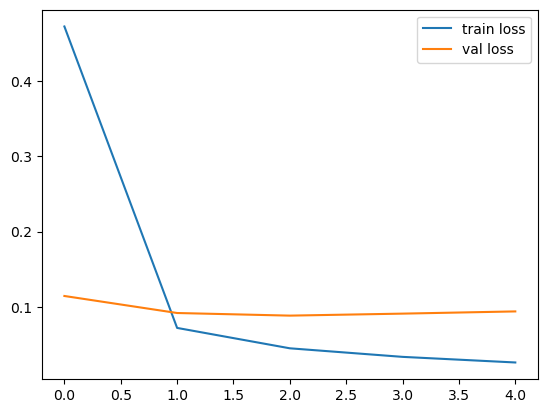

In [23]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

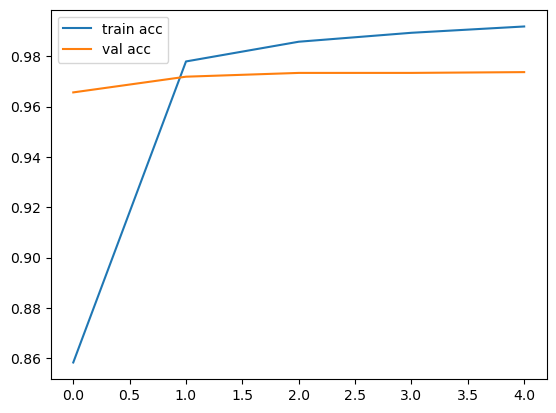

In [24]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [25]:
#now as a sanity check we'll ensure the accuracy computed above is correct and ensure that mask_zero is actually correct
# True model accuracy - above includes padding

# first get length of each sequence
train_lengths = []
for sentence in train_inputs:
  train_lengths.append(len(sentence))

test_lengths = []
for sentence in test_inputs:
  test_lengths.append(len(sentence))

In [26]:
train_probs = model.predict(train_inputs_int) # N x T x K, output shape includes padding
#returns probabilities or logits
#we wanna get predictions without padding we're gonna loop through probs and lengths
#inside the loop we'll grab only the first part of the sequence which is not padded
train_predictions = [] 

#####BU TARZ İKİ TERMLÜ LOOPLARI İYİ ANLA
for probs, length in zip(train_probs, train_lengths):
  # probs is T x K
  probs_ = probs[-length:] ## aa burda bakıyo atıyorum sequence length 6 ise probs[-6:] yapınca son 6'yı almış oluyo
    #yani non padded'lar çünkü padding'in zero ları en başa konur
  preds = np.argmax(probs_, axis=1) #o prob'ların her biri T-length x K, axis 1 diyince K'ya göre argmax alıyo glb
  train_predictions.append(preds) ## ee burda pred'ler ney pos-tag'in ismi mi yoksa integer hali mi

# flatten
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets_int_unpadded)

1255/1255 [==============================] - 48s 30ms/step


In [27]:
train_predictions #integer haliymiş

[array([1, 3]),
 array([4, 7, 5, 1, 4, 5, 1, 3, 8, 2, 2, 5, 1, 4, 1, 3]),
 array([5, 1, 4, 5, 2, 1, 2, 7, 2, 4, 1, 1, 4, 5, 1, 3]),
 array([ 5,  6,  1,  4,  5,  1,  2,  4,  1,  1,  1,  1,  3,  1,  1,  3,  1,
         3,  4,  3,  6,  1,  1,  3,  9, 11,  1,  4,  1,  1,  3,  1,  1,  3,
         1, 11,  3,  9,  5, 12,  4,  1,  3,  1,  1,  3]),
 array([8, 2, 4, 5, 1, 8, 3]),
 array([3, 1, 7, 7, 3]),
 array([ 8,  2,  2, 10,  2,  5,  6,  1,  4,  2,  1,  1,  9,  1,  1,  4,  5,
         1,  3,  6,  4, 11,  1,  4,  5,  6,  1,  3,  4,  2,  1,  4,  5,  4,
         5, 11,  1,  4,  4,  5,  1,  4, 10, 11,  1,  9, 11,  4,  5,  1,  2,
         2,  7,  4,  5,  1,  1,  3]),
 array([4, 3, 8, 2, 5, 1, 4, 1, 4, 1, 2, 2, 5, 1, 3]),
 array([ 3,  2,  4,  8,  3,  1,  3, 10,  2,  6,  4,  5,  1,  3]),
 array([ 5,  1,  8,  2,  5,  1, 10,  2, 10,  4,  5,  1,  4, 11,  4,  5,  6,
         1,  1,  4,  5,  1,  3]),
 array([3, 1, 1, 3, 6, 1, 3, 2, 2, 6, 3]),
 array([1, 3]),
 array([ 4,  7,  1,  2,  2,  4,  6,  4,  5,  1

In [28]:
#same thing for the test set
test_probs = model.predict(test_inputs_int) # N x T x K
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  test_predictions.append(preds)

# flatten
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets_int_unpadded)

#this is bcz the methods to compute metrics in sklearn do not take nested list, so we convert ours to the 1-d lists.

538/538 [==============================] - 19s 36ms/step


In [29]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:",
      f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:",
      f1_score(flat_test_targets, flat_test_predictions, average='macro'))


#our model works fine, as you see f1 is a bit less optimistic than the accuracy since probably our classes imbalanced

Train acc: 0.9942700894975053
Test acc: 0.9736916613519953
Train f1: 0.9869753886291512
Test f1: 0.9297312531098112


#### keep a note of above scores so we can compare our model to a baseline model
yani bu az önce yaptığımız mı baseline oldu?
- yok öylr olmamış
- dedi ki it means nothing if we don't have a baseline to compare if our model works better or owrse
- so to establish the baseline we re gonna build the simplest model possible
- for each word in train set, we'll keep track of the all possible tags assigned
- then just map it to the most common tag
- WUT?

In [30]:
### Baseline model: map word to tag
from collections import Counter

# https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
def most_common(lst):
  data = Counter(lst)
  return data.most_common(1)[0][0] ###burdaki 1-0-0 ne içindi?


In [31]:
token2tags = {k: [] for k, v in word2idx.items()}
#This code initializes a dictionary called token2tags with keys taken from the word2idx dictionary 
#and empty lists as their corresponding values.
#so for each tpken there will be an empty list for value

# remove UNK token
del token2tags['UNK']

for tokens, tags in zip(train_inputs, train_targets):
  for token, tag in zip(tokens, tags):
    if should_lowercase: #false demiştik, true da yapabiliriz bu kodla
      token = token.lower()
    if token in token2tags:
      token2tags[token].append(tag)

token2tag = {k: most_common(v) for k, v in token2tags.items()}
#k,v olan dict'te her k'ya en yaygın v değerini atıyo
#ama anlamadığım her k'ya o k'ya atanmış en yaygın v'yi mi atıyo
#yani start mesela, bazen verb bazen noun ama en yaygını hangisiyse tüm start'lar o değeri mi alıyo
#yoksa tüm kelimeler mi en yaygın değeri alıyo?

#tekrar most common'a bakalım:
#def most_common(lst):
  #data = Counter(lst)
  #return data.most_common(1)[0][0] ###burdaki 1-0-0 ne içindi?

#tekrar loop'a dikkat et! token.append(tag) kısmı aynı token'a birden fazla tag vermeni mümkün kılıyo.
#token2tags[token] sana o ilgili token'a ait en başta yarattığımız empty list'i verir normalde
#append diyince, her corresponding tag sırayla yan yana yazılıyo

#yani key-value pair olarak key: token, value: a list of corresponding tags by looped order
#value bir list olduğu için 
#en alt satırda most_common fonksiyonun objesi de hakkaten tanımladığımız gibi list olmuş oluyo
#for k,v in toekn2tags.items():
# k: most_common(v) olacak şekilde yeni bi dict yarattık! tmm


### Chatgpt:
- It defines a function called most_common that takes a list (lst) as input.
- Within the most_common function, it creates a Counter object called data, which counts the occurrences of each element in the input list.
- It returns the most common element from the data object by using the most_common(1) method, which returns a list of tuples containing the most common elements and their counts. [0][0] is used to access the first element of the first tuple, which corresponds to the most common element itself.
- Outside the most_common function, it uses a dictionary comprehension to create a new dictionary called token2tag. It iterates over the items in the token2tags dictionary, where each key-value pair represents a token and its corresponding list of tags.
- For each key-value pair, it assigns the key (k) to the token2tag dictionary, and the result of calling the most_common function on the value (v) is assigned as the corresponding value in the token2tag dictionary. Essentially, it finds the most common tag in the list of tags for each token and assigns it as the value in the token2tag dictionary.
- In summary, this code calculates the most common tag for each token based on the tags associated with it in the token2tags dictionary, and stores the results in a new dictionary called token2tag.


In [33]:
token2tag

{'the': 'DET',
 ',': '.',
 '.': '.',
 'of': 'ADP',
 'and': 'CONJ',
 'to': 'PRT',
 'a': 'DET',
 'in': 'ADP',
 'that': 'ADP',
 'is': 'VERB',
 'was': 'VERB',
 'for': 'ADP',
 '``': '.',
 "''": '.',
 'The': 'DET',
 'with': 'ADP',
 'it': 'PRON',
 'as': 'ADP',
 'he': 'PRON',
 'his': 'DET',
 'on': 'ADP',
 'be': 'VERB',
 ';': '.',
 'had': 'VERB',
 'I': 'PRON',
 'by': 'ADP',
 'at': 'ADP',
 '?': '.',
 'not': 'ADV',
 'are': 'VERB',
 'from': 'ADP',
 'or': 'CONJ',
 'this': 'DET',
 'have': 'VERB',
 'an': 'DET',
 'which': 'DET',
 '--': '.',
 'were': 'VERB',
 'but': 'CONJ',
 'He': 'PRON',
 'her': 'DET',
 'one': 'NUM',
 'they': 'PRON',
 'you': 'PRON',
 'all': 'PRT',
 'would': 'VERB',
 'their': 'DET',
 'him': 'PRON',
 ')': '.',
 '(': '.',
 'has': 'VERB',
 'been': 'VERB',
 'will': 'VERB',
 'who': 'PRON',
 'out': 'PRT',
 'more': 'ADV',
 'It': 'PRON',
 'we': 'PRON',
 'she': 'PRON',
 'said': 'VERB',
 'up': 'PRT',
 'there': 'PRT',
 'its': 'DET',
 'In': 'ADP',
 'about': 'ADP',
 'into': 'ADP',
 'them': 'PRON',


In [32]:
train_inputs #is a list of lists o yüzden ilk for loop cümleleri eşliyo
#ikinci for loop cümle içindeki kelimeleri tagleriyle eşlito

[['Mines', '.'],
 ['With',
  'just',
  'the',
  'hydrogen',
  'of',
  'our',
  'bodies',
  ',',
  'we',
  'could',
  'run',
  'the',
  'world',
  'for',
  'years',
  '.'],
 ['The',
  'dirt',
  'on',
  'the',
  'soiled',
  'objects',
  'is',
  'mechanically',
  'held',
  'by',
  'surface',
  'irregularities',
  'to',
  'some',
  'extent',
  '.'],
 ['The',
  'American',
  'part',
  'of',
  'the',
  'evening',
  'consisted',
  'of',
  'Paul',
  "Creston's",
  'Dance',
  'Overture',
  ',',
  'William',
  "Schuman's",
  '``',
  'Chester',
  "''",
  'From',
  '``',
  'New',
  'England',
  'Triptych',
  "''",
  'and',
  'two',
  'works',
  'of',
  'Wallingford',
  'Riegger',
  ',',
  'Dance',
  'Rhythms',
  ',',
  'Op.',
  '58',
  ',',
  'and',
  'a',
  'Romanza',
  'For',
  'Strings',
  ',',
  'Op.',
  '56A',
  '.'],
 ['He', 'goes', 'to', 'the', 'chief', 'himself', '.'],
 [')', 'Tillich', 'as', 'well', '.'],
 ['We',
  'have',
  'attempted',
  'to',
  'simplify',
  'the',
  'extensive',
  'ta

In [34]:
# compute accuracy

train_predictions = []
for sentence in train_inputs:
  predictions = []
  for token in sentence:
    if should_lowercase:
      token = token.lower()
    predicted_tag = token2tag[token]
    predictions.append(predicted_tag)
  train_predictions.append(predictions)
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets)

In [35]:
test_predictions = []
for sentence in test_inputs:
  predictions = []
  for token in sentence:
    predicted_tag = token2tag.get(token, 'INCORRECT')
    predictions.append(predicted_tag)
  test_predictions.append(predictions)
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets)


In [36]:
print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:",
      f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:",
      f1_score(flat_test_targets, flat_test_predictions, average='macro'))

#so as you see hte baseline model is pretty good and it makes sense
#because for most words, they only have one possible tag
#and even when there are multiple possible tags, it's still more common to use those words in one way than another
# yet our model performs better than the baseline!
#which proves that accounting for the context is useful and better than simply memorizing the tag for each word

Train acc: 0.9571661464565124
Test acc: 0.9283105636602309
Train f1: 0.939133394016589
Test f1: 0.8233535721892226


### Exercises:
- 1) use different layers (GRU, SimpleRNN), different number of hidden units, number of layers, etc. as before
    - Also, repeat the exercise with CNNs instead of RNNs
- 2) repeat the same code, but include the 2 mistakes
    - Mistake #1: not having an OOV token (target len != input len, misalignment)
    - Also, verify that target misalignment exists
    - Mistake #2: not ignoring padding in loss computation (thinking that zeros are targets tho they not represent pos-tags)
    - Observe that you get 99% accuracy, even with a bad model. (with those mistakes)
- 3) why is the accuracy so high? (discuss on Q&A with your peers)

I've seen these mistakes on Kaggle and on blogs (you know how I like to read a.k.a. judge bad DS/ML bloggers and marketers). The mistake arises from "trusting the library too much", assuming you can just use the Tokenizer() with default values and Embedding() with default values, and not thinking about what they actually do.

#### i.e. it's important to THINK, not just "use libraries".